In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import chainer
from chainer import Variable
from chainer import Chain
import chainer.functions as F
import chainer.links as L
from chainer.optimizers import rmsprop

import gym

In [11]:
class MLP(Chain):
    
    def __init__(self, obs_size, n_units=64):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_units)
            self.l1 = L.Linear(n_units, 2 * n_units)
            self.l2 = L.Linear(2 * n_units, n_units)
            
    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return F.relu(self.l2(h))  

In [12]:
class ActorCritic(Chain):
    
    def __init__(self, shared_model, n_actions):
        super(ActorCritic, self).__init__()
        with self.init_scope():
            self.shared_model = shared_model
            
            self.actor = L.Linear(None, n_actions)
            self.critic = L.Linear(None, 1)
    
    
    def __call__(self, x):
        h = self.shared_model(x)
    
        pi = F.softmax(self.actor(h))
        v = self.critic(h)
        return pi, v

In [13]:
obs_shape = (2,3)
a = np.zeros([2 + 1, 5] + list(obs_shape))
print(a.shape, a.reshape([-1] + list(a.shape)).shape)

a = np.zeros((1,4))
print(a.flatten().shape)

(3, 5, 2, 3) (1, 3, 5, 2, 3)
(4,)


_compute_returns illustration

In [14]:
update_steps = 5
gamma = 0.99
returns = np.zeros(update_steps + 1)
rewards = [1, 1, 1, 1, 1]
next_val = 9
returns[-1] = next_val 
for i in reversed(range(update_steps)):
    returns[i] = rewards[i] + gamma * returns[i + 1]

print(returns)

[ 13.45990546  12.58576309  11.702791    10.8109       9.91         9.        ]


In [19]:
class A2CAgent(object):
    
    def __init__(self, model, optimizer, n_steps, gamma, phi=lambda x: x, 
                 pi_loss_coef=1.0, v_loss_coef=0.5,
                 average_actor_loss_decay=0.999,
                 average_value_decay=0.999,
                ):
        
        self.model = model
        self.optimizer = optimizer
        self.n_steps = n_steps
        self.gamma = gamma
        self.phi = phi
        self.pi_loss_coef = pi_loss_coef
        self.v_loss_coef = v_loss_coef
    
        self.step = 0
        self.start_step = 0
    
        self.average_actor_loss_decay = average_actor_loss_decay
        self.average_value_decay = average_value_decay
    
        # Stats
        self.average_actor_loss = 0
        self.average_value = 0
    
    def _compute_returns(self, next_value):
        
        self.returns[-1] = next_value
        for i in reversed(range(self.n_steps)):
            self.returns[i] = self.rewards[i] + \
                self.gamma * self.returns[i + 1]
    
    def _reset_storage(self, state, p_out):
        
#         self.states = self.xp.zeros(
#             [self.update_steps + 1, self.num_processes] + list(obs_shape),
#             dtype='f')
#         self.actions = self.xp.zeros(
#             [self.update_steps, self.num_processes] + list(action_shape),
#             dtype=action.dtype)
#         self.rewards = self.xp.zeros(
#             (self.update_steps, self.num_processes, 1), dtype='f')
#         self.value_preds = self.xp.zeros(
#             (self.update_steps + 1, self.num_processes, 1), dtype='f')
#         self.returns = self.xp.zeros(
#             (self.update_steps + 1, self.num_processes, 1), dtype='f')

        self.states = np.zeros((self.n_steps + 1,) + state.shape, dtype=np.float32)
        self.action_log_probs = np.zeros(self.n_steps, dtype=np.float32)
        self.rewards = np.zeros(self.n_steps, dtype=np.float32)
        self.value_preds = np.zeros(self.n_steps + 1, dtype=np.float32)
        self.returns = np.zeros(self.n_steps + 1, dtype=np.float32)
    
    def update(self):
        #print(len(self.states), len(self.actions), len(self.rewards), len(self.value_preds), len(self.returns))
        
        # print(np.dtype(self.states.flatten()[0]))
        
        # print(type(self.states[-1].flatten()[0]))
        _, next_value = self.model(self.states[-1])
        next_value = next_value.data

        self._compute_returns(next_value)
#         pout, values = \
#             self.model.pi_and_v(chainer.Variable(
#                 self.states[:-1].reshape([-1] + list(self.obs_shape))))
        p_out, values = self.model(chainer.Variable(self.states[:-1]))

#         actions = chainer.Variable(
#             self.actions.reshape([-1] + list(self.action_shape)))
#         dist_entropy = F.mean(pout.entropy)
#         action_log_probs = pout.log_prob(actions)
        # dist_entropy = ???
        
#         values = values.reshape(self.update_steps, self.num_processes, 1)
#         action_log_probs = action_log_probs.reshape(
#             self.update_steps, self.num_processes, 1)
#         advantages = chainer.Variable(self.returns[:-1]) - values
        # print(self.returns.shape)
        advantages = chainer.Variable(self.returns[:-1].reshape(-1, 1)) - values
        value_loss = F.mean(advantages * advantages)
        action_loss = - F.mean(chainer.Variable(advantages.data) * self.action_log_probs.reshape(-1, 1))
        
        self.model.cleargrads()

        (value_loss * self.v_loss_coef +
         action_loss * self.pi_loss_coef).backward()
         # - dist_entropy * self.entropy_coeff).backward()

        self.optimizer.update()
        self.states[0] = self.states[-1]

        # Update stats
        self.average_actor_loss += (
            (1 - self.average_actor_loss_decay) *
            (action_loss.data.astype(np.float32) - self.average_actor_loss))
        self.average_value += (
            (1 - self.average_value_decay) *
            (value_loss.data.astype(np.float32) - self.average_value))
#         self.average_entropy += (
#             (1 - self.average_entropy_decay) *
#             (float(dist_entropy.data) - self.average_entropy))
        self.start_step = self.step
    
    
    def act_and_train(self, state, reward, done):

#         statevar = self.batch_states([state], self.xp, self.phi)[0]
        state = self.phi(state)
        
        if self.step == 0:
#             pout, _ = self.model.pi_and_v(statevar[0:1])
#             action = pout.sample().data
            p_out, _ = self.model(state)
            action = np.random.choice(n_actions, p=p_out.data.flatten())
            self._reset_storage(state, p_out)
        
#         self.rewards[self.t - self.t_start -1] \
#             = self.xp.array(reward, dtype=self.xp.float32)
#         self.states[self.t - self.t_start] = statevar
    
        # self.rewards.append(reward)
        self.rewards[self.step - self.start_step - 1] = np.array(reward, dtype=np.float32)
        # self.states.append(state)
        #print( type(state))
        self.states[self.step - self.start_step] = state

        if self.step - self.start_step == self.n_steps:
            self.update()
            
        p_out, value = self.model(state)
        action = np.random.choice(n_actions, p=p_out.data.flatten())
        # action = env.action_space.sample()  # random
        
#         self.actions[self.t - self.t_start] \
#             = action.reshape([-1] + list(self.action_shape))
#         self.value_preds[self.t - self.t_start] = value.data
        self.action_log_probs[self.step - self.start_step] = F.log(p_out)[0][action].data
        # self.actions.append(action) 
        self.value_preds[self.step - self.start_step] = value.data
        # self.value_preds.append(0)

        self.step += 1
            
        return action
        # return env.action_space.sample()  # random
    
    def act(self, obs):

        pass
    
    def stop_episode_and_train(self, state, reward, done=False):
        
        state = self.phi(state)
        self.rewards[self.step - self.start_step - 1] = np.array(reward, dtype=np.float32)
        self.states[self.step - self.start_step] = state

        self.update()
#         if done:
#             self.update(None)
#         else:
#             state = self.phi(state)

#             self.update(state)
            
    def get_statistics(self):
        return [
            ('average_actor_loss', self.average_actor_loss),
            ('average_value', self.average_value),
        ]

In [23]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)
print(env.observation_space.low.size)
print(env.action_space.n)

[2018-02-04 21:45:47,066] Making new env: CartPole-v0


Discrete(2)
Box(4,)
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]
[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
4
2


[2018-02-04 21:45:48,276] Making new env: CartPole-v0
/home/kg/miniconda3/envs/gym/lib/python3.6/site-packages/chainer/functions/math/exponential.py:51: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),


episode: 10 R: 10.0 statistics: [('average_actor_loss', 0.0025074274086547472), ('average_value', 19889.809324190373)]
episode: 20 R: 10.0 statistics: [('average_actor_loss', 0.0024552946729064253), ('average_value', 25724.64195975542)]
episode: 30 R: 10.0 statistics: [('average_actor_loss', 0.0024066524982581535), ('average_value', 26879.516872609867)]
episode: 40 R: 10.0 statistics: [('average_actor_loss', 0.0023589739803068235), ('average_value', 27640.789534456111)]
episode: 50 R: 9.0 statistics: [('average_actor_loss', 0.0023099277878914351), ('average_value', 349611.15350193187)]
episode: 60 R: 9.0 statistics: [('average_actor_loss', 0.0022641654962515037), ('average_value', 598440.41536814044)]
episode: 70 R: 10.0 statistics: [('average_actor_loss', 0.0022193098075569619), ('average_value', 591379.68762109382)]
episode: 80 R: 9.0 statistics: [('average_actor_loss', 0.0021753427609743112), ('average_value', 583826.79897670925)]
episode: 90 R: 9.0 statistics: [('average_actor_loss

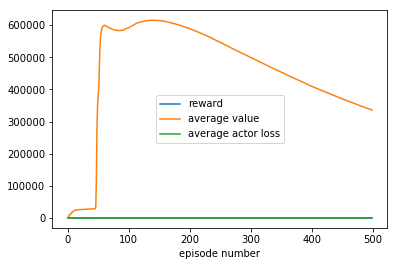

In [24]:
env = gym.make('CartPole-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5
n_episodes = 500

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

preprocessor = lambda x: x.astype(np.float32).reshape((-1,) + x.shape)
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=preprocessor)

rewards_per_episode = []
average_value_per_episode = []
average_actor_loss_per_episode = []

for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    rewards_per_episode.append(R)
    average_value_per_episode.append(agent.get_statistics()[1][1])
    average_actor_loss_per_episode.append(agent.get_statistics()[0][1])
    if i % 10 == 0:
        print('episode:', i,
              'R:', R,
              'statistics:', agent.get_statistics()
             )
    agent.stop_episode_and_train(obs, reward, done)

print('Finished.')
plt.plot(rewards_per_episode)
plt.plot(average_value_per_episode)
plt.plot(average_actor_loss_per_episode)
plt.xlabel("episode number")
# plt.ylabel("reward")
plt.legend(["reward", "average value", "average actor loss"])

/home/galias/miniconda2/envs/gym/lib/python3.6/site-packages/chainer/functions/math/exponential.py:51: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),


episode: 1 R: 0.0 statistics: [('average_actor_loss', 8.203524547296747e-06), ('average_value', 3088.669954311215)]
episode: 2 R: 0.0 statistics: [('average_actor_loss', 7.905401116745408e-06), ('average_value', 2976.4224238777397)]
episode: 3 R: 0.0 statistics: [('average_actor_loss', 7.180986439717089e-06), ('average_value', 2871.1252852999014)]
episode: 4 R: 1.0 statistics: [('average_actor_loss', 0.00042498496495772516), ('average_value', 2752.9778073995208)]
episode: 5 R: 2.0 statistics: [('average_actor_loss', 0.001125655483935707), ('average_value', 2608.1898678484704)]
episode: 6 R: 3.0 statistics: [('average_actor_loss', 0.0022609134643614454), ('average_value', 2439.086557175695)]
episode: 7 R: 2.0 statistics: [('average_actor_loss', 0.0029009780628014466), ('average_value', 2287.8039350309577)]
episode: 8 R: 3.0 statistics: [('average_actor_loss', 0.0038943847623502106), ('average_value', 2148.052888981413)]
episode: 9 R: 3.0 statistics: [('average_actor_loss', 0.00303305815

episode: 72 R: 2.0 statistics: [('average_actor_loss', 0.004904131926293194), ('average_value', 95.00219676304151)]
episode: 73 R: 2.0 statistics: [('average_actor_loss', 0.00502454720020928), ('average_value', 90.2773676840075)]
episode: 74 R: 0.0 statistics: [('average_actor_loss', 0.004096459361368432), ('average_value', 87.17079919274339)]
episode: 75 R: 0.0 statistics: [('average_actor_loss', 0.0033211244531452964), ('average_value', 84.08695784903895)]
episode: 76 R: 1.0 statistics: [('average_actor_loss', 0.0033877575171409715), ('average_value', 80.54669872155834)]
episode: 77 R: 2.0 statistics: [('average_actor_loss', 0.003975442091089584), ('average_value', 75.77919680632077)]
episode: 78 R: 1.0 statistics: [('average_actor_loss', 0.003131136809584634), ('average_value', 71.93770528351732)]
episode: 79 R: 0.0 statistics: [('average_actor_loss', 0.0025464549263318603), ('average_value', 69.53175757545037)]
episode: 80 R: 0.0 statistics: [('average_actor_loss', 0.00210988133637

episode: 142 R: 3.0 statistics: [('average_actor_loss', 0.004669186785737533), ('average_value', 2.7935441029064076)]
episode: 143 R: 1.0 statistics: [('average_actor_loss', 0.003677810125106807), ('average_value', 2.670762946171169)]
episode: 144 R: 3.0 statistics: [('average_actor_loss', 0.0037621654156117464), ('average_value', 2.493900410099802)]
episode: 145 R: 1.0 statistics: [('average_actor_loss', 0.0033175737423645824), ('average_value', 2.3775234646682413)]
episode: 146 R: 0.0 statistics: [('average_actor_loss', 0.002535399213814904), ('average_value', 2.295717565266366)]
episode: 147 R: 2.0 statistics: [('average_actor_loss', 0.003616825053670181), ('average_value', 2.167940059380914)]
episode: 148 R: 3.0 statistics: [('average_actor_loss', 0.00588019859515953), ('average_value', 2.0402798132842013)]
episode: 149 R: 4.0 statistics: [('average_actor_loss', 0.008237299060012184), ('average_value', 1.8981204377186407)]
episode: 150 R: 0.0 statistics: [('average_actor_loss', 0.0

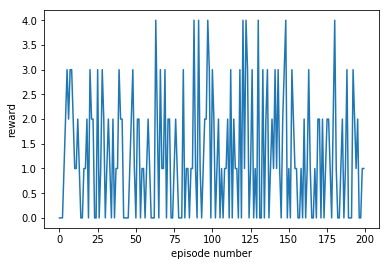

In [341]:
env = gym.make('Breakout-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5
n_episodes = 200

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

frame_preprocessor = lambda x: (x.astype(np.float32) / 255).reshape((-1,) + x.shape)
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

rewards_per_episode = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while not done:
        # Uncomment to watch the behaviour
        # env.render()
        action = agent.act_and_train(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    rewards_per_episode.append(R)
    #if i % 10 == 0:
    print('episode:', i,
          'R:', R,
          'statistics:', agent.get_statistics()
         )
    agent.stop_episode_and_train(obs, reward, done)

print('Finished.')
plt.plot(rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward")

Discrete(4)


/home/galias/miniconda2/envs/gym/lib/python3.6/site-packages/chainer/functions/math/exponential.py:51: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),


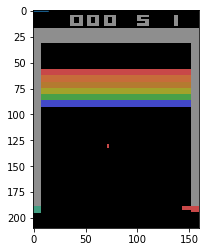

In [331]:
env = gym.make('Breakout-v0')
print(env.action_space)
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 5

model = ActorCritic(shared_model=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.RMSprop()
optimizer.setup(model)

frame_preprocessor = lambda x: (x.astype(np.float32) / 255).reshape([-1] + list(x.shape))
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

# print("states actions rewards value_preds returns")

obs = env.reset()
reward = 0
done = False
R = []

for _ in range(15):
    plt.imshow(env.render(mode='rgb_array'))
    action = agent.act_and_train(obs, reward, done)
    _obs, reward, done, _ = env.step(action)
    obs = _obs
    R.append(reward)
    if done:
        obs = env.reset()
        reward = 0
        done = False
plt.plot(np.cumsum(R))

In [ ]:
import logging
import sys
gym.undo_logger_setup()  # Turn off gym's default logger settings
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

chainerrl.experiments.train_agent_with_evaluation(
    agent, env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_runs=10,       # 10 episodes are sampled for each evaluation
    max_episode_len=200,  # Maximum length of each episodes
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result')      # Save everything to 'result' directory

example qfunction (?)

In [ ]:
import chainer 
import chainer.functions as F
import chainer.links as L
import chainerrl
import gym
import numpy as np

from chainer import cuda

import datetime
from skimage.color import rgb2gray
from skimage.transform import resize

env = gym.make('Breakout-v0')
obs = env.reset()

print("observation space   : {}".format(env.observation_space))
print("action space        : {}".format(env.action_space))

action = env.action_space.sample()
obs, r, done, info = env.step(action)
class QFunction(chainer.Chain):
def __init__(self,obs_size, n_action):
    super(QFunction, self).__init__(
        l1=L.Convolution2D(obs_size, 4, ksize=2,pad=1),#210x160
        bn1=L.BatchNormalization(4),
        l2=L.Convolution2D(4, 4, ksize=2,pad=1),#105x80
        bn2=L.BatchNormalization(4),
        #l3=L.Convolution2D(64, 64, ksize=2, pad=1),#100x100
        #bn3=L.BatchNormalization(64),
        #l4=L.Convolution2D(64, 3, ksize=2,pad=1),#50x50
       # bn4=L.BatchNormalization(3),

        l5=L.Linear(972, 512),
        out=L.Linear(512, n_action, initialW=np.zeros((n_action, 512), dtype=np.float32))
    )

def __call__(self, x, test=False):

    h1=F.relu(self.bn1(self.l1(x)))
    h2=F.max_pooling_2d(F.relu(self.bn2(self.l2(h1))),2)
    #h3=F.relu(self.bn3(self.l3(h2)))
    #h4=F.max_pooling_2d(F.relu(self.bn4(self.l4(h3))),2)
    #print h4.shape

    return chainerrl.action_value.DiscreteActionValue(self.out(self.l5(h2)))

n_action = env.action_space.n
obs_size = env.observation_space.shape[0] #(210,160,3)
q_func = QFunction(obs_size, n_action)

optimizer = chainer.optimizers.Adam(eps=1e-2)
optimizer.setup(q_func)

gamma = 0.99

explorer = chainerrl.explorers.ConstantEpsilonGreedy(
epsilon=0.2, random_action_func=env.action_space.sample)

replay_buffer = chainerrl.replay_buffer.ReplayBuffer(capacity=10 ** 6)

phi = lambda x: x.astype(np.float32, copy=False)
agent = chainerrl.agents.DoubleDQN(
q_func, optimizer, replay_buffer, gamma, explorer,
minibatch_size=4, replay_start_size=100, update_interval=10,
target_update_interval=10, phi=phi)

last_time = datetime.datetime.now()
n_episodes = 10000
for i in range(1, n_episodes + 1):
obs = env.reset()

reward = 0
done = False
R = 0

while not done:
    env.render()
    action = agent.act_and_train(obs, reward)
    obs, reward, done, _ = env.step(action)


    if reward != 0:
        R += reward

elapsed_time = datetime.datetime.now() - last_time
print('episode:', i, 
      'reward:', R,
     )
last_time = datetime.datetime.now()

if i % 100 == 0:
    filename = 'agent_Breakout' + str(i)
    agent.save(filename)

agent.stop_episode_and_train(obs, reward, done)
print('Finished.')

In [29]:
class CNN(chainer.Chain):
    
    def __init__(self, train=True):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 1, 1, initialW=np.array([[[[1]]]])) ,
            l1 = L.Linear(None, 1, initialW=np.array([[1,1,1,1]]))  
        )

    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.sigmoid(self.l1(h))
        return h


net = CNN()
net.cleargrads()
optimizer = chainer.optimizers.SGD()
optimizer.setup(net)

optimizer.setup(net)
net.conv1.W.update_rule.enabled = False
# net.conv1.disable_update()  # also works

result = net(np.random.random((1,1,2,2)).astype(np.float32))
print("conv1 weights:",net.conv1.W.data)
print("l1 weigths:",net.l1.W.data)
loss = F.mean_absolute_error(result,np.array([[0.1]],dtype=np.float32))
loss.backward()
optimizer.update()
print("conv1 grad",net.conv1.W.grad)
print("after update...")
print("conv1 weights:",net.conv1.W.data)
print("l1 weights:",net.l1.W.data)

conv1 weights: [[[[ 1.]]]]
l1 weigths: [[ 1.  1.  1.  1.]]
conv1 grad [[[[ 0.19457532]]]]
after update...
conv1 weights: [[[[ 1.]]]]
l1 weights: [[ 0.99955279  0.99984294  0.99892896  0.99972951]]


pyTorch tutorial